# EECS 545 (WN 2024) Homework 4: RNNs and Image Captioning

<span class="instruction">Before starting the assignment, please fill in the following cell.</span>

In [50]:
###################################################################
# Enter your first and last name, e.g. "John Doe"                 #
# for example                                                     #
# __NAME__ = "Anthony Liu"                                        #
# __UNIQID__ = "anthliu"                                          #
###################################################################
# raise NotImplementedError("TODO: Add your implementation here.")
__NAME__ = "Yuzhou Chen"
__UNIQID__ = "yzc"
###################################################################
#                        END OF YOUR CODE                         #
###################################################################

print(f"Your name and email: {__NAME__} <{__UNIQID__}@umich.edu>")
assert __NAME__ and __UNIQID__

Your name and email: Yuzhou Chen <yzc@umich.edu>


# RNNs and Image Captioning
In this notebook, you will test your RNN implementation from `rnn.py` on the coco image captioning dataset.

## Setup code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook. Let's start by checking whether we are using Python 3.11 or higher.

In [51]:
import sys
if sys.version_info[0] < 3:
    raise Exception("You must use Python 3")

if sys.version_info[1] < 11:
    print("Autograder will execute your code based on Python 3.11 environment. Please use Python 3.11 or higher to prevent any issues")
    print("You can create a conda environment with Python 3.11 like 'conda create --name eecs545 python=3.11'")
    raise Exception("Python 3 version is too low: {}".format(sys.version))
else:
    print("You are good to go")

You are good to go


First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Then, we run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [53]:
# install required libraries
# !pip install numpy==1.24.1 matplotlib==3.6.2 scikit-learn==1.2.0 h5py==3.8.0 imageio==2.25.1

# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# set figure size
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [54]:
from IPython.display import display_html, HTML

display_html(HTML('''
<style type="text/css">
  .instruction { background-color: yellow; font-weight:bold; padding: 3px; }
</style>
'''));

Running the following cell allow us to import from `rnn_layers.py` and `rnn.py`. If it works correctly, it should print the message:
```Hello from rnn_layers.py``` and ```Hello from rnn.py```

In [55]:
from rnn_layers import hello
from rnn import hello as hello2
hello()
hello2()

Hello from rnn_layers.py!
Hello from rnn.py!


# Image Captioning


## What is COCO?

[COCO](https://cocodataset.org/) (Common Objects in COntext) is a large-scale object detection, segmentation, and captioning dataset.

COCO has 330K images (>200K labeled)! Labelled images have object segmentations, and captions.

![COCO examples](https://cocodataset.org/images/coco-examples.jpg)


## Loading COCO

Please download the dataset (987Mb) from [this link](https://drive.google.com/file/d/1RjZTIVp4ES1Ewv1QAJgCS_7DYyJa-Yf1/view?usp=sharing) and unzip the folder into the data directory.
```
HW4 /
--| image_captioning.ipynb
--| data /
----| coco_captioning /
------| coco2014_captions.h5
------| ...
```

The dataset contains the preprocessed features and captions from the COCO dataset.

In [56]:
# !pip install h5py
import coco_utils

MAX_TRAIN = 200# We'll train with a very small dataset

# Load COCO data from disk; this returns a dictionary
small_data = coco_utils.load_coco_data(max_train=MAX_TRAIN)

## Visualizing COCO

Let's check out some images in our COCO dataset. You can browse the full dataset [here](https://cocodataset.org/#explore)! My favourite image is [this one](https://cocodataset.org/#explore?id=314526). It turns out when you have a 330K image dataset, some of the images might be really [weird](https://blog.roboflow.com/coco-dataset-image-search/). Check it out!

Let's visualize some images from the downloaded COCO. Note we have to load them from the URL since they aren't stored in our dataset. (We save the preprocessed features). Some of these images may not load properly because the URLs are no longer active.

In [57]:
def md_table(urls, captions, cols=5):
    table = '|   ' * cols + '|\n' + '|---' * cols + '|\n'
    row = lambda idxs: '| ' + ' | '.join(f'![train image {i}]({urls[i]})' for i in idxs) + ' |'
    row_cap = lambda idxs: '| ' + ' | '.join(f'**{str(captions[i])}**' for i in idxs) + ' |'
    table += '\n'.join(row(range(i, i+cols)) + '\n' + row_cap(range(i, i+cols)) for i in range(0, len(urls), cols))
    table = table.replace('<', '\<')# show angle brackets in MD
    table = table.replace('\<br>', '<br>')# keep <br> as newline
    return table

In [58]:
from IPython.display import Markdown as md
n_imgs = 20
rng = np.random.default_rng(545)
captions, features, img_urls = coco_utils.sample_coco_minibatch(
    small_data, split='train', batch_size=n_imgs, seed=545)
cap_str = [coco_utils.decode_captions(c, small_data['idx_to_word']) for c in captions]
md(md_table(img_urls, cap_str))

|   |   |   |   |   |
|---|---|---|---|---|
| ![train image 0](http://farm4.staticflickr.com/3828/9515372128_e874a589fa_z.jpg) | ![train image 1](http://farm9.staticflickr.com/8093/8362722159_5c76891fba_z.jpg) | ![train image 2](http://farm6.staticflickr.com/5480/9706351564_6b7001868e_z.jpg) | ![train image 3](http://farm5.staticflickr.com/4052/5162428391_872f641b4a_z.jpg) | ![train image 4](http://farm1.staticflickr.com/51/105582257_149d0b1007_z.jpg) |
| **\<START> two people walking down a street holding an umbrella \<END>** | **\<START> the plate is filled with meat and vegetables \<END>** | **\<START> tennis player in a tennis court \<UNK> with her tennis racket \<END>** | **\<START> a man in a blue shirt holding a white plate with some food on it \<END>** | **\<START> a \<UNK> vase being displayed in a \<UNK> \<END>** |
| ![train image 5](http://farm9.staticflickr.com/8016/7268221008_3e953f93dd_z.jpg) | ![train image 6](http://farm5.staticflickr.com/4081/4751171578_2137e00d34_z.jpg) | ![train image 7](http://farm9.staticflickr.com/8462/8036487923_12f8c0b71e_z.jpg) | ![train image 8](http://farm8.staticflickr.com/7366/9889727824_ae51c4077f_z.jpg) | ![train image 9](http://farm8.staticflickr.com/7409/10194986376_61bbeac653_z.jpg) |
| **\<START> a person is standing on the water on a \<UNK> board \<END>** | **\<START> a traffic signal with a very big pretty building by it \<END>** | **\<START> a very big room with a big pretty clock \<END>** | **\<START> many beautiful fruit \<UNK> line the shelves in the market \<END>** | **\<START> a double decker green bus driving down a \<UNK> road near a lake \<END>** |
| ![train image 10](http://farm4.staticflickr.com/3202/2345517887_36ef2e7551_z.jpg) | ![train image 11](http://farm9.staticflickr.com/8010/7643240678_82fdaa2f60_z.jpg) | ![train image 12](http://farm4.staticflickr.com/3346/3616813166_ff18a41f6f_z.jpg) | ![train image 13](http://farm9.staticflickr.com/8452/8041161824_c6da3831c1_z.jpg) | ![train image 14](http://farm7.staticflickr.com/6121/5917556272_2448eabaa4_z.jpg) |
| **\<START> a large green hotel sign on the corner \<END>** | **\<START> \<UNK> \<UNK> on a street with traffic behind it \<END>** | **\<START> the \<UNK> stands next to the \<UNK> as a batter is swinging \<END>** | **\<START> a cat is standing on a seat of a toilet \<END>** | **\<START> a pizza with \<UNK> \<UNK> \<UNK> and cheese \<END>** |
| ![train image 15](http://farm4.staticflickr.com/3645/3571849552_9afdac5dec_z.jpg) | ![train image 16](http://farm4.staticflickr.com/3117/2636949743_56a878209d_z.jpg) | ![train image 17](http://farm2.staticflickr.com/1414/1366775115_58ff6b6cd3_z.jpg) | ![train image 18](http://farm4.staticflickr.com/3277/3089235227_1560b21f11_z.jpg) | ![train image 19](http://farm9.staticflickr.com/8453/8018484689_ec5a2594d2_z.jpg) |
| **\<START> \<UNK> a flat toilet in a small bathroom \<END>** | **\<START> a \<UNK> tennis match \<UNK> \<UNK> on a grass court \<END>** | **\<START> a \<UNK> with several \<UNK> pictures on it \<END>** | **\<START> a small bathroom with a \<UNK> looking toilet and sink \<END>** | **\<START> a cow with an ear \<UNK> is standing in tall grass \<END>** |

Footnote: Special tokens. \<START> and \<END> tokens denote the start and end of the captions.
The \<UNK> token is created during preprocessing and replaces words that do not occur in the dataset very often. Doing this sometimes helps the model learn better since it shrinks the vocabulary!

## Training
Next, we'll train an RNN to predict captions on COCO. <span class="instruction">Make sure you have implemented `temporal_fc_forward` and `temporal_fc_backward` in `rnn_layers.py`, and `CaptioningRNN` from `rnn.py`.</span>
Read through `captioning_solver.py` to make sure you understand the API. 

### Correctness Checks

Like `cnn.ipynb`, we have included some tests to check your implementation. However, we have left the numerical gradient checks blank.
These checks are optional, but they may be helpful for debugging. Hint: follow the same steps as done in `cnn.ipynb`.

In [59]:
from gradient_check import rel_error, eval_numerical_gradient, eval_numerical_gradient_array
from rnn_layers import temporal_fc_backward, temporal_fc_forward

# OPTIONAL TODO Test with eval_numerical_gradient_array.
# Hint: Start by sampling some random test data. (Refer to the rnn_layers.py comments to check the shapes)
# Then, call eval_numerical_gradient_array on the test data. (Refer to cnn.ipynb for examples)
# Compare the results of eval_numerical_gradient_array with your own backward implementation.


In [60]:
from gradient_check import rel_error, eval_numerical_gradient, eval_numerical_gradient_array
from rnn import CaptioningRNN

# Generate dummy test data
wtoi = {f'{i}': i for i in range(7)}# dummy word to index
wtoi['<NULL>'] = 8
wtoi['<START>'] = 9
wtoi['<END>'] = 10
np.random.seed(0)
test_rnn_model = CaptioningRNN(
      cell_type='rnn',
      word_to_idx=wtoi,
      input_dim=5,
      hidden_dim=4,
      wordvec_dim=5,
)
rng = np.random.default_rng(545)
X = rng.standard_normal((2, 5))
y = rng.integers(0, 10, size=(2, 4))

print('Testing training loss...')
loss, grads = test_rnn_model.loss(X, y)

assert np.abs(loss - 7.783337014604364) < 1e-4, 'loss should be close.'

# OPTIONAL TODO Test with eval_numerical_gradient_array.
# Hint: write a loop to check each grad (Refer to cnn.ipynb for examples)


print('done.')

Testing training loss...
done.


In [61]:
# Generate dummy test data
wtoi = {f'{i}': i for i in range(7)}# dummy word to index
wtoi['<NULL>'] = 8
wtoi['<START>'] = 9
wtoi['<END>'] = 10
np.random.seed(1)
test_rnn_model = CaptioningRNN(
      cell_type='rnn',
      word_to_idx=wtoi,
      input_dim=5,
      hidden_dim=4,
      wordvec_dim=5,
)
rng = np.random.default_rng(545)
X = rng.standard_normal((2, 5))

print('Testing rnn sample...')
captions = test_rnn_model.sample(X, max_length=17)
gt_captions = np.array([[1, 0, 7, 2, 1, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       [6, 5, 1, 0, 7, 6, 5, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7]])
assert np.all(captions == gt_captions)
print('Done.')

Testing rnn sample...
Done.


### Initializing the model

In [62]:
from rnn import CaptioningRNN
from captioning_solver import CaptioningSolver

np.random.seed(0)
# Experiment with vanilla RNN
small_rnn_model = CaptioningRNN(
      cell_type='rnn',
      word_to_idx=small_data['word_to_idx'],
      input_dim=small_data['train_features'].shape[1],
      hidden_dim=512,
      wordvec_dim=256,
)

small_rnn_solver = CaptioningSolver(small_rnn_model, small_data,
       update_rule='adam',
       num_epochs=58,
       batch_size=25,
       optim_config={
         'learning_rate': 4e-3,
       },
       lr_decay=0.95,
       verbose=True, print_every=10,
     )

### Train!

Remember to include the plot of your learning curves in the final report.

In [63]:
small_rnn_solver.train()

(Iteration 1 / 464) loss: 77.461908
(Iteration 11 / 464) loss: 56.948375
(Iteration 21 / 464) loss: 35.118544
(Iteration 31 / 464) loss: 22.324996
(Iteration 41 / 464) loss: 19.796825
(Iteration 51 / 464) loss: 7.753935
(Iteration 61 / 464) loss: 7.885911
(Iteration 71 / 464) loss: 3.529135
(Iteration 81 / 464) loss: 2.363732
(Iteration 91 / 464) loss: 2.608455
(Iteration 101 / 464) loss: 0.984790
(Iteration 111 / 464) loss: 0.636966
(Iteration 121 / 464) loss: 0.337632
(Iteration 131 / 464) loss: 0.270756
(Iteration 141 / 464) loss: 0.693979
(Iteration 151 / 464) loss: 0.232704
(Iteration 161 / 464) loss: 0.173717
(Iteration 171 / 464) loss: 0.175537
(Iteration 181 / 464) loss: 0.143498
(Iteration 191 / 464) loss: 0.162632
(Iteration 201 / 464) loss: 0.141661
(Iteration 211 / 464) loss: 0.126652
(Iteration 221 / 464) loss: 0.144719
(Iteration 231 / 464) loss: 0.107181
(Iteration 241 / 464) loss: 0.142200
(Iteration 251 / 464) loss: 0.133118
(Iteration 261 / 464) loss: 0.118951
(Iterat

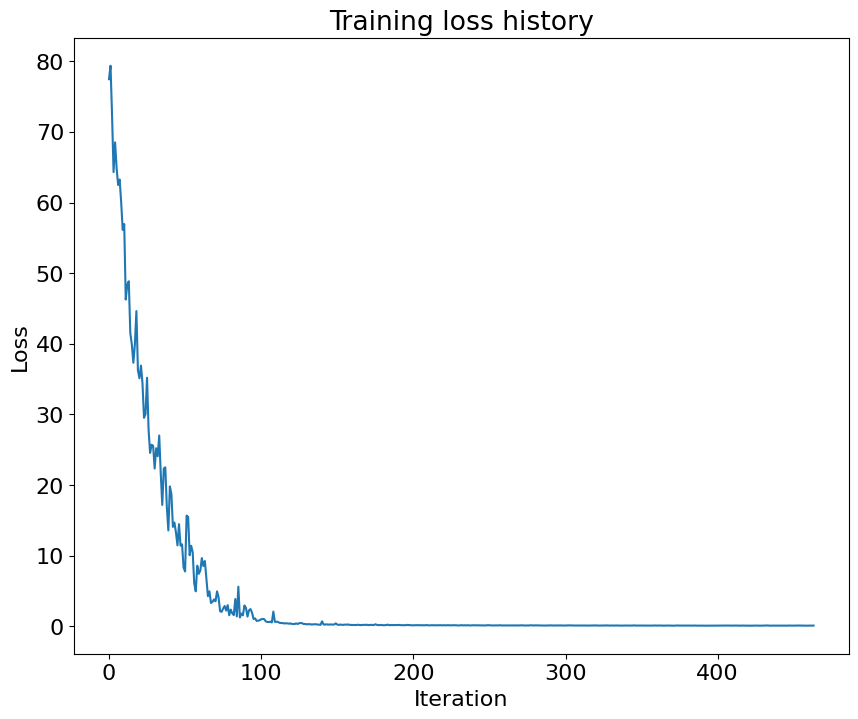

In [64]:
# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.savefig('image_captioning_loss.png', dpi=256)
plt.show()
plt.close()

### Testing and Visualization

Finally, let's test our model on some validation data. Include your generated train and validation captions in the final report.

In [65]:
from image_utils import image_from_url

tables = {}
for split in ['train', 'val']:
    # some images might be deprecated. You may rerun the code several times
    # to successfully get the sample images from url.
    minibatch = coco_utils.sample_coco_minibatch(
        small_data, split=split, batch_size=10, seed=545)
    gt_captions, features, urls = minibatch
    gt_captions = coco_utils.decode_captions(gt_captions,
                                             small_data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = coco_utils.decode_captions(sample_captions,
                                                 small_data['idx_to_word'])

    figure_caption = [f'Sample: {sample_cap} <br> GT: {gt_cap}' for sample_cap, gt_cap in zip(sample_captions, gt_captions)]
    tables[split] = md_table(urls, figure_caption)


In [66]:
md('## Training samples \n ' + tables['train'])

## Training samples 
 |   |   |   |   |   |
|---|---|---|---|---|
| ![train image 0](http://farm4.staticflickr.com/3828/9515372128_e874a589fa_z.jpg) | ![train image 1](http://farm9.staticflickr.com/8093/8362722159_5c76891fba_z.jpg) | ![train image 2](http://farm6.staticflickr.com/5480/9706351564_6b7001868e_z.jpg) | ![train image 3](http://farm5.staticflickr.com/4052/5162428391_872f641b4a_z.jpg) | ![train image 4](http://farm1.staticflickr.com/51/105582257_149d0b1007_z.jpg) |
| **Sample: two people walking down a street holding an umbrella \<END> <br> GT: \<START> two people walking down a street holding an umbrella \<END>** | **Sample: the plate is filled with meat and vegetables \<END> <br> GT: \<START> the plate is filled with meat and vegetables \<END>** | **Sample: tennis player in a tennis court \<UNK> with her tennis racket \<END> <br> GT: \<START> tennis player in a tennis court \<UNK> with her tennis racket \<END>** | **Sample: a man in a blue shirt holding a white plate with some food on it \<END> <br> GT: \<START> a man in a blue shirt holding a white plate with some food on it \<END>** | **Sample: a \<UNK> vase being displayed in a \<UNK> \<END> <br> GT: \<START> a \<UNK> vase being displayed in a \<UNK> \<END>** |
| ![train image 5](http://farm9.staticflickr.com/8016/7268221008_3e953f93dd_z.jpg) | ![train image 6](http://farm5.staticflickr.com/4081/4751171578_2137e00d34_z.jpg) | ![train image 7](http://farm9.staticflickr.com/8462/8036487923_12f8c0b71e_z.jpg) | ![train image 8](http://farm8.staticflickr.com/7366/9889727824_ae51c4077f_z.jpg) | ![train image 9](http://farm8.staticflickr.com/7409/10194986376_61bbeac653_z.jpg) |
| **Sample: a person is standing on the water on a \<UNK> board \<END> <br> GT: \<START> a person is standing on the water on a \<UNK> board \<END>** | **Sample: a traffic signal with a very big pretty building by it \<END> <br> GT: \<START> a traffic signal with a very big pretty building by it \<END>** | **Sample: a very big room with a big pretty clock \<END> <br> GT: \<START> a very big room with a big pretty clock \<END>** | **Sample: many beautiful fruit \<UNK> line the shelves in the market \<END> <br> GT: \<START> many beautiful fruit \<UNK> line the shelves in the market \<END>** | **Sample: a double decker green bus driving down a \<UNK> road near a lake \<END> <br> GT: \<START> a double decker green bus driving down a \<UNK> road near a lake \<END>** |

In [67]:
md('## Validation samples \n ' + tables['val'])

## Validation samples 
 |   |   |   |   |   |
|---|---|---|---|---|
| ![train image 0](http://farm1.staticflickr.com/98/232570195_3d29e80f86_z.jpg) | ![train image 1](http://farm8.staticflickr.com/7182/6859527791_a1cd7af962_z.jpg) | ![train image 2](http://farm4.staticflickr.com/3023/2672786915_248cfd7c62_z.jpg) | ![train image 3](http://farm8.staticflickr.com/7261/7580453970_335fceee54_z.jpg) | ![train image 4](http://farm8.staticflickr.com/7070/7123518753_26f8ede211_z.jpg) |
| **Sample: \<UNK> \<UNK> on a table near the boat \<END> <br> GT: \<START> a herd of sheep that are walking through a large group of people \<END>** | **Sample: playing \<UNK> at a \<UNK> \<END> <br> GT: \<START> a row of vintage cars in a grassy field \<END>** | **Sample: a pizza with a \<UNK> in the \<UNK> \<END> <br> GT: \<START> the young man is \<UNK> the young woman on top of her head \<END>** | **Sample: sitting on a a tennis on top of a \<UNK> \<END> <br> GT: \<START> a young man carrying a surf board under his arm \<END>** | **Sample: cow man one standing on a \<UNK> on a \<UNK> \<END> <br> GT: \<START> an image of a man on the beach riding horse \<END>** |
| ![train image 5](http://farm9.staticflickr.com/8051/8388343572_d2a0f62c1a_z.jpg) | ![train image 6](http://farm5.staticflickr.com/4114/4850716846_7f8b2fa27c_z.jpg) | ![train image 7](http://farm3.staticflickr.com/2330/1510813540_6fcf299cca_z.jpg) | ![train image 8](http://farm6.staticflickr.com/5258/5501327196_fd90312cb5_z.jpg) | ![train image 9](http://farm4.staticflickr.com/3110/2291542385_92312a2810_z.jpg) |
| **Sample: a man and a the \<UNK> on a baseball across a \<UNK> \<END> <br> GT: \<START> a person holding a baseball bat in a \<UNK> cage \<END>** | **Sample: a man and up a truck \<UNK> with a \<UNK> street \<END> <br> GT: \<START> a woman is reading on a park bench beside a \<UNK> \<END>** | **Sample: a person on a jacket and on \<UNK> \<UNK> to the \<END> <br> GT: \<START> a person who is surfing in a wave pool \<END>** | **Sample: there woman a woman next to a forest \<END> <br> GT: \<START> a man that is surfing on a wave in water \<END>** | **Sample: the \<UNK> with a \<UNK> on \<UNK> \<UNK> a the \<UNK> \<END> <br> GT: \<START> a meal of sandwiches potatoes and red \<UNK> beer \<END>** |